<a href="https://colab.research.google.com/github/alphaxiao1/alphaxiao1/blob/main/chapters/chap07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limits to Growth

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

Here's the data from the previous chapter again.

In [3]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

Downloaded World_population_estimates.html


In [4]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison',
                  'hyde', 'tanton', 'biraben', 'mj',
                  'thomlinson', 'durand', 'clark']

In [5]:
un = table2.un / 1e9
census = table2.census / 1e9

And here are the functions from the previous chapter.

In [6]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap06.py')

Downloaded chap06.py


In [7]:
from chap06 import run_simulation

def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year',
             ylabel='World population (billions)')

In the previous chapter we developed a population model where net growth during each time step is proportional to the current population. This model seems more realistic than the constant growth model, but it does not fit the data as well.

There are a few things we could try to improve the model:

-   Maybe net growth depends on the current population, but the
    relationship is quadratic, not linear.

-   Maybe the net growth rate varies over time.

In this chapter, we'll explore the first option.
In the exercises, you will have a chance to try the second.

## Quadratic Growth

It makes sense that net growth should depend on the current population, but maybe it's not a linear relationship, like this:

```
net_growth = system.alpha * pop
```

Maybe it's a quadratic relationship, like this:

```
net_growth = system.alpha * pop + system.beta * pop**2
```

We can test that conjecture with a new update function:

In [8]:
def growth_func_quad(t, pop, system):
    return system.alpha * pop + system.beta * pop**2

Here's the `System` object we'll use, initialized with `t_0`, `p_0`, and `t_end`.

In [9]:
t_0 = census.index[0]
p_0 = census[t_0]
t_end = census.index[-1]

system = System(t_0=t_0,
                p_0=p_0,
                t_end=t_end)

Now we have to add the parameters `alpha` and `beta` .
I chose the following values by trial and error; we'll see better ways to do it later.

In [10]:
system.alpha = 25 / 1000
system.beta = -1.8 / 1000

And here's how we run it:

In [11]:
results = run_simulation(system, growth_func_quad)

Here are the results.

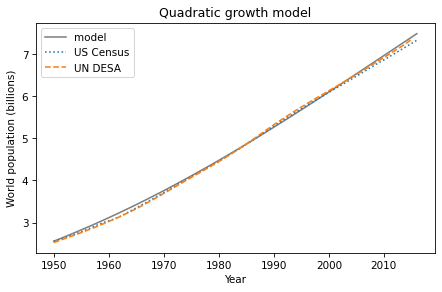

In [12]:
results.plot(color='gray', label='model')
plot_estimates()
decorate(title='Quadratic growth model')

The model fits the data well over the whole range, with just a bit of space between them in the 1960s.

It is not entirely surprising that the quadratic model fits better than the
constant and proportional models, because it has two parameters we can
choose, where the other models have only one. In general, the more
parameters you have to play with, the better you should expect the model
to fit.

But fitting the data is not the only reason to think the quadratic model
might be a good choice. It also makes sense; that is, there is a
legitimate reason to expect the relationship between growth and
population to have this form.

To understand it, let's look at net growth as a function of population.

## Net Growth

Let's plot the relationship between growth and population in the quadratic model.
I'll use `linspace` to make an array of 101 populations from 0 to 15 billion.

In [13]:
from numpy import linspace

pop_array = linspace(0, 15, 101)

Now I'll use the quadratic model to compute net growth for each population.

In [14]:
growth_array = (system.alpha * pop_array +
                system.beta * pop_array**2)

To plot growth rate versus population, we'll use the `plot` function from Matplotlib.
First we have to import it:

In [15]:
from matplotlib.pyplot import plot

Now we can use it like this:

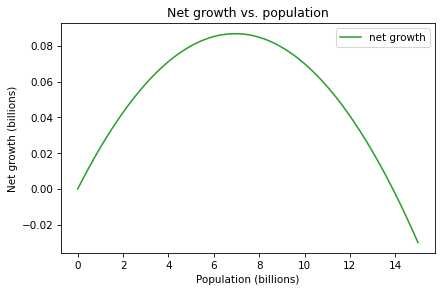

In [16]:
plot(pop_array, growth_array, label='net growth', color='C2')

decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)',
         title='Net growth vs. population')

Note that the x-axis is not time, as in the previous figures, but population. We can divide this curve into four kinds of behavior:

-   When the population is less than 3 billion, net growth is
    proportional to population, as in the proportional model. In this
    range, the population grows slowly because the population is small.

-   Between 3 billion and 10 billion, the population grows quickly
    because there are a lot of people.

-   Above 10 billion, population grows more slowly; this behavior models
    the effect of resource limitations that decrease birth rates or
    increase death rates.

-   Above 14 billion, resources are so limited that the death rate
    exceeds the birth rate and net growth becomes negative.

Just below 14 billion, there is a point where net growth is 0, which
means that the population does not change. At this point, the birth and death rates are equal, so the population is in *equilibrium*.

## Finding Equilibrium

The equilibrium point is the population, $p$, where net population growth, $\Delta p$, is 0.
We can compute it by finding the roots, or zeros, of this equation:

$$\Delta p = \alpha p + \beta p^2$$

where $\alpha$ and $\beta$ are the parameters of the model.
If we rewrite the right-hand side like this:

$$\Delta p = p (\alpha + \beta p)$$

we can see that net growth is $0$ when $p=0$ or $p=-\alpha/\beta$.
So we can compute the (non-zero) equilibrium point like this:

In [17]:
-system.alpha / system.beta

13.88888888888889

With these parameters, net growth is 0 when the population is about 13.9 billion
(the result is positive because `beta` is negative).

In the context of population modeling, the quadratic model is more
conventionally written like this:

$$\Delta p = r p (1 - p / K)$$

This is the same model; it's just a different way to *parameterize* it. Given $\alpha$ and $\beta$, we can compute $r=\alpha$ and $K=-\alpha/\beta$.

In this version, it is easier to interpret the parameters: $r$ is the
unconstrained growth rate, observed when $p$ is small, and $K$ is the
equilibrium point.
$K$ is also called the *carrying capacity*, since it indicates the maximum population the environment can sustain.

## Summary

In this chapter we implemented a quadratic growth model where net growth depends on the current population and the population squared.
This model fits the data well, and we saw one reason why: it is based on the assumption that there is a limit to the number of people the Earth can support.

In the next chapter we'll use the models we have developed to generate
predictions.
But first, I want to warn you about a few things that can go wrong when you write functions.

## Dysfunctions

When people learn about functions, there are a few things they often
find confusing. In this section I'll present and explain some common
problems.

As an example, suppose you want a function that takes a
`System` object, with variables `alpha` and `beta`, and computes the
carrying capacity, `-alpha/beta`.
Here's a good solution:

In [18]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K

sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


Now let's see all the ways that can go wrong.

*Dysfunction #1:* Not using parameters. In the following version, the function doesn't take any parameters; when `sys1` appears inside the function, it refers to the object we create outside the function.

In [19]:
def carrying_capacity():
    K = -sys1.alpha / sys1.beta
    return K

sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity()
print(pop)

13.88888888888889


This version works, but it is not as versatile as it could be.
If there are several `System` objects, this function can work with only one of them, and only if it is named `sys1`.

*Dysfunction #2:* Clobbering the parameters. When people first learn
about parameters, they often write functions like this:

In [23]:
# WRONG
def carrying_capacity(system):
    system = System(alpha=0.025, beta=-0.0018)
    K = -system.alpha / system.beta
    return K

sys1 = System(alpha=0.03, beta=-0.009)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


In this example, we have a `System` object named `sys1` that gets passed
as an argument to `carrying_capacity`. But when the function runs, it
ignores the argument and immediately replaces it with a new `System`
object. As a result, this function always returns the same value, no
matter what argument is passed.

When you write a function, you generally don't know what the values of
the parameters will be. Your job is to write a function that works for
any valid values. If you assign your own values to the parameters, you
defeat the whole purpose of functions.

*Dysfunction #3:* No return value. Here's a version that computes the value of `K` but doesn't return it.

In [24]:
# WRONG
def carrying_capacity(system):
    K = -system.alpha / system.beta

sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

None


A function that doesn't have a return statement actually returns a special value called `None`, so in this example the value of `pop` is `None`. If you are debugging a program and find that the value of a variable is `None` when it shouldn't be, a function without a return statement is a likely cause.

*Dysfunction #4:* Ignoring the return value. Finally, here's a version where the function is correct, but the way it's used is not.

```
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
carrying_capacity(sys1)   # WRONG
print(K)
```

In this example, `carrying_capacity` runs and returns `K`, but the
return value doesn't get displayed or assigned to a variable.
If we try to print `K`, we get a `NameError`, because `K` only exists inside the function.

When you call a function that returns a value, you should do something
with the result.

## Exercises

### Exercise 1

 In a previous section, we saw a different way to parameterize the quadratic model:

$$ \Delta p = r p (1 - p / K) $$

where $r=\alpha$ and $K=-\alpha/\beta$.  

Write a version of `growth_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025` and `beta=-0.0018`, and confirm that you get the same results.

In [28]:
def growth_func_quad1(t, pop, system):
    r = system.alpha
    K = -system.alpha/system.beta
    return r * pop*(1-pop/K)

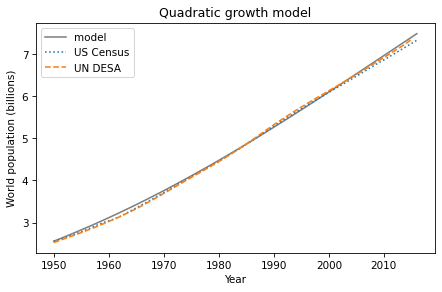

In [29]:
t_0 = census.index[0]
p_0 = census[t_0]
t_end = census.index[-1]

system = System(t_0=t_0,
                p_0=p_0,
                t_end=t_end)

system.alpha = 25 / 1000
system.beta = -1.8 / 1000

results = run_simulation(system, growth_func_quad1)

results.plot(color='gray', label='model')
plot_estimates()
decorate(title='Quadratic growth model')

In [ ]:
# Solution goes here

### Exercise 2

  What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

Hint: If there are too many labels in the legend, you can plot results like this:

```
    results.plot(label='_nolegend')
```


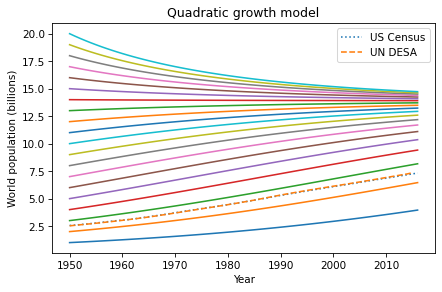

In [32]:
# prompt: What happens if we start with an initial population above the carrying capacity, like 20 billion? Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modsim import *

# Load the census data
# census = pd.read_csv('census.csv', index_col='Year')

# Define the growth function
def growth_func(t, pop, system):
    r = system.alpha
    K = -system.alpha/system.beta
    return r * pop*(1-pop/K)

# Set up the simulation
t_0 = census.index[0]
p_0 = census[t_0]
t_end = census.index[-1]

system = System(t_0=t_0,
                p_0=p_0,
                t_end=t_end)

system.alpha = 25 / 1000
system.beta = -1.8 / 1000

# Run the simulation for different initial populations
p_inits = np.linspace(1, 20, 20)
results = []
for p_init in p_inits:
    system.p_0 = p_init
    results.append(run_simulation(system, growth_func))

# Plot the results
for result in results:
    result.plot(label='_nolegend')

plot_estimates()
decorate(title='Quadratic growth model')

# Show the plot
plt.show()


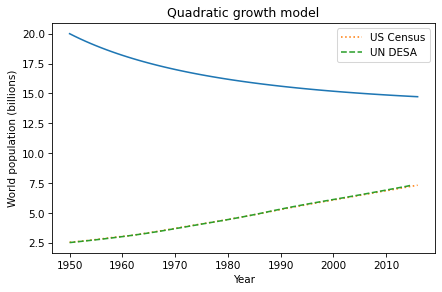

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modsim import *

# Load the census data
# census = pd.read_csv('census.csv', index_col='Year')

# Define the growth function
def growth_func(t, pop, system):
    r = system.alpha
    K = -system.alpha/system.beta
    return r * pop*(1-pop/K)

# Set up the simulation
t_0 = census.index[0]
p_0 = 20
t_end = census.index[-1]

system = System(t_0=t_0,
                p_0=p_0,
                t_end=t_end)

system.alpha = 25 / 1000
system.beta = -1.8 / 1000

# Run the simulation for different initial populations

results = run_simulation(system, growth_func)

# Plot the results

results.plot(label='_nolegend')

plot_estimates()
decorate(title='Quadratic growth model')

# Show the plot
plt.show()